In [1]:
#import os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#import Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

#Visual
from matplotlib.image import imread

import glob

#import Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint, EarlyStopping

#Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import random
folder_asli = "Dataset/cats_vs_dogs/train/"
folder_resize = "Dataset/cats_vs_dogs/ResizeZ/"
nama_file = os.listdir(folder_asli)
random.shuffle(nama_file) # mengacak susunan file_names

for i in range(6000):
  filename = nama_file[i]
  img_path = folder_asli+filename

  img = Image.open(img_path)
  img = img.resize((224, 224))
  img = img.convert('RGB')

  newImgPath = folder_resize+filename
  img.save(newImgPath)


In [3]:
nama_file = os.listdir('Dataset/cats_vs_dogs/ResizeZ/')

dog_count = 0
cat_count = 0

for img_file in nama_file:

  name = img_file[0:3]

  if name == 'dog':
    dog_count += 1

  else:
    cat_count += 1

print('Number of dog images =', dog_count)
print('Number of cat images =', cat_count)

Number of dog images = 2993
Number of cat images = 3007


In [4]:
image_dir = "Dataset/cats_vs_dogs/ResizeZ/"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,cat.1.jpg,cat
1,cat.10003.jpg,cat
2,cat.10006.jpg,cat
3,cat.10007.jpg,cat
4,cat.10009.jpg,cat


In [5]:
# train test split using dataframe

labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state = 80)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 80)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (4800, 2)
The shape of test data (600, 2)
The shape of validation data (600, 2)


In [6]:
# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# parameters
image_size = 150
image_channel = 3
bat_size = 32

In [8]:
# Applying image data gernerator to train and test data

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = 'Dataset/cats_vs_dogs/ResizeZ/',
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val, 
                                                 directory = 'Dataset/cats_vs_dogs/ResizeZ/',
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test, 
                                                  directory = 'Dataset/cats_vs_dogs/ResizeZ/',
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 4800 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


In [9]:
mobnetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [10]:
#pada layer nya kami mengambil GlobalPooling, Dropout, dll
model = mobnetV2.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(2,activation='softmax')(model)
model = tf.keras.models.Model(inputs=mobnetV2.input, outputs = model)

In [11]:
#mengatur konfigurasi pelatihan model
model.compile(loss='binary_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])

In [12]:

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

In [14]:
# melatih model dengan menggunakan data pelatihan train_generator menggunakan fungsi fit()
history = model.fit(train_generator, validation_data = val_generator, epochs=11, batch_size=32,
callbacks=[ learning_rate_reduction])

Epoch 1/11
150/150 [==============================] - 58s 385ms/step - loss: 0.2820 - accuracy: 0.8883 - val_loss: 1.0236 - val_accuracy: 0.8617
Epoch 2/11
150/150 [==============================] - 51s 342ms/step - loss: 0.2198 - accuracy: 0.9223 - val_loss: 1.0431 - val_accuracy: 0.7900
Epoch 3/11
150/150 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9335
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
150/150 [==============================] - 46s 310ms/step - loss: 0.1639 - accuracy: 0.9335 - val_loss: 1.5112 - val_accuracy: 0.7917
Epoch 4/11
150/150 [==============================] - 60s 397ms/step - loss: 0.0950 - accuracy: 0.9633 - val_loss: 0.7388 - val_accuracy: 0.9267
Epoch 5/11
150/150 [==============================] - 53s 352ms/step - loss: 0.0822 - accuracy: 0.9698 - val_loss: 0.3915 - val_accuracy: 0.9433
Epoch 6/11
150/150 [==============================] - 45s 297ms/step - loss: 0.0784 - accuracy: 0.9700 - val_l

In [15]:
# prediction
result = model.predict(test_generator,batch_size = bat_size,verbose = 1)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

labels =['Cat','Dog']
print(classification_report(y_true, y_pred,target_names=labels))

19/19 [==============================] - 1s 78ms/step
              precision    recall  f1-score   support

         Cat       0.96      0.94      0.95       301
         Dog       0.94      0.96      0.95       299

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



Model predict terdeteksi Anjing


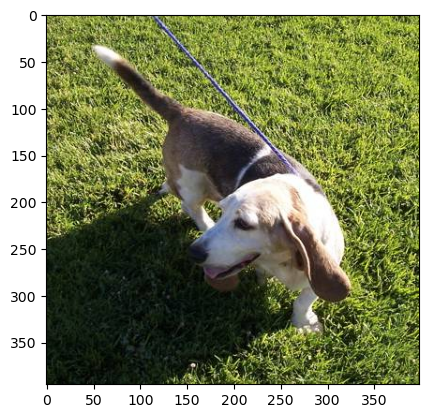

In [24]:
#Melakukan Percobaan Hasil Pelatihan
input_image_path = input('Path of the image to be predicted: ')
img = cv2.imread(input_image_path)
opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
plt.imshow(opencvImage)
img = cv2.resize(opencvImage, (150,150))
img = img.reshape(1,150,150,3)
p = model.predict(img)
p = np.argmax(p, axis=1)[0]

if p==0:
    p='Kucing'
elif p==1:
    p='Anjing'
else:
    print('model tidak terdeteksi')

if p!=3:
    print(f'Model predict terdeteksi {p}')